<a href="https://colab.research.google.com/github/snghynn/summ/blob/main/kaggle4_Customers_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mall Customers Segmentation
# 1. Introduction
- "Clustering": to discover natural groups within UNLABELED(unsupervised) dataset
- most known application
  - customers segmentation
  - image segmentation
  - documents clusterisation

- clustering with two main types
  - Hierarchical algorithms
    - split a dataset into smaller subset until a subset
    - contdendrogram: represented with a tree-shaped
    - [agglomerative approach] from leaves to the root
    - [divisive approach] from root to the leaves

  - Partitional algorithms
    - divide a dataset into several subsets(clusters) based on a given criteria
    - number of clusters has to be defined(K-Means)/ no defining(DBSCAN)
    - defining number of clusters before running requires a specific domain knowledge
    - led to the devlp of heuristics and simplified approaches helping analyst w/o domain knowledge

- No single one that dominates other ones
- Choosing the best depends on
  - the db itself
  - application domain
  - client requirements & expectations

# 2. Reading data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [3]:
mall_data = pd.read_csv('Mall_Customers.csv')
print('There are {} rows and {} columns in our dataset.'.format(mall_data.shape[0],mall_data.shape[1]))

There are 200 rows and 5 columns in our dataset.


In [4]:
mall_data.sample(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
160,161,Female,56,79,35
118,119,Female,51,67,43
15,16,Male,22,20,79
198,199,Male,32,137,18
197,198,Male,32,126,74
171,172,Male,28,87,75
120,121,Male,27,67,56
50,51,Female,49,42,52
73,74,Female,60,50,56
139,140,Female,35,74,72


In [5]:
mall_data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


> There are 5 columns:

- Customer ID - numerical - unique customer number - integer

- Gender - categorical - binary (Male/Female)

  -> **Need one-hot encoding. But not in here **

- Age - numerical - integer

- Annual Income (k$) - numerical - integer

- Spending Score (1-100) - numerical - integer

In [6]:
mall_data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

> No missing data

# 3. Exploratory Data Analysis
## 3.1 Distributions

Data will be stratified by gender: the only categorical variable

### a. age

<ipython-input-7-90e711b08c1a>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(males_age, bins=age_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
<ipython-input-7-90e711b08c1a>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(females_age, bins=age_bins, kd

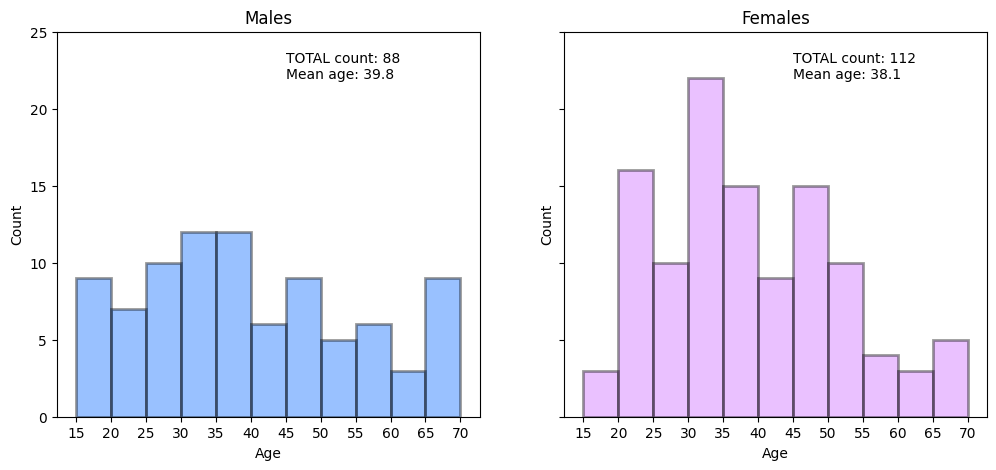

In [7]:
males_age = mall_data[mall_data['Gender']=='Male']['Age'] # subset with males age
females_age = mall_data[mall_data['Gender']=='Female']['Age'] # subset with females age

age_bins = range(15,75,5)

# males histogram
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)
sns.distplot(males_age, bins=age_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(age_bins)
ax1.set_ylim(top=25)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(45,23, "TOTAL count: {}".format(males_age.count()))
ax1.text(45,22, "Mean age: {:.1f}".format(males_age.mean()))

# females histogram
sns.distplot(females_age, bins=age_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(age_bins)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(45,23, "TOTAL count: {}".format(females_age.count()))
ax2.text(45,22, "Mean age: {:.1f}".format(females_age.mean()))

plt.show()

In [21]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_age, females_age)[1]))

Kolgomorov-Smirnov test p-value: 0.49


> - avg age of male is higher than female
> - dist of male age is more uniform
- kolgomorov-Smirnov test: diff btw two groups are statistically insignificant

### b. income

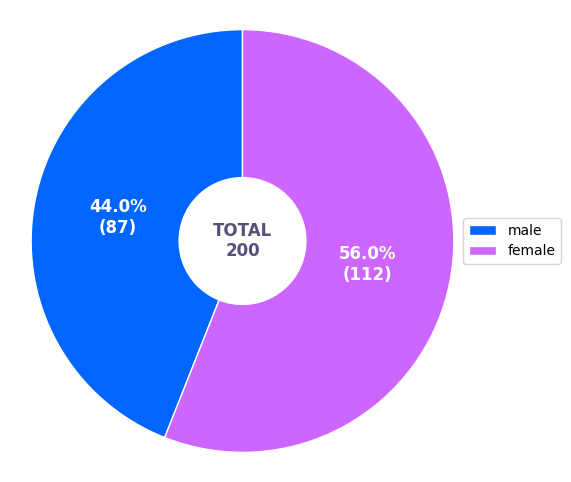

In [8]:
def labeler(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

sizes = [males_age.count(),females_age.count()] # wedge sizes

fig0, ax1 = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax1.pie(sizes,
                                   autopct=lambda pct: labeler(pct, sizes),
                                   radius=1,
                                   colors=['#0066ff','#cc66ff'],
                                   startangle=90,
                                   textprops=dict(color="w"),
                                   wedgeprops=dict(width=0.7, edgecolor='w'))

ax1.legend(wedges, ['male','female'],
           loc='center right',
           bbox_to_anchor=(0.7, 0, 0.5, 1))

plt.text(0,0, 'TOTAL\n{}'.format(mall_data['Age'].count()),
         weight='bold', size=12, color='#52527a',
         ha='center', va='center')

plt.setp(autotexts, size=12, weight='bold')
ax1.axis('equal')  # Equal aspect ratio
plt.show()

> - more female customers(56%)

<ipython-input-9-0d86fc4a2b23>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(males_income, bins=my_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
<ipython-input-9-0d86fc4a2b23>:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(females_income, bins=my_bins

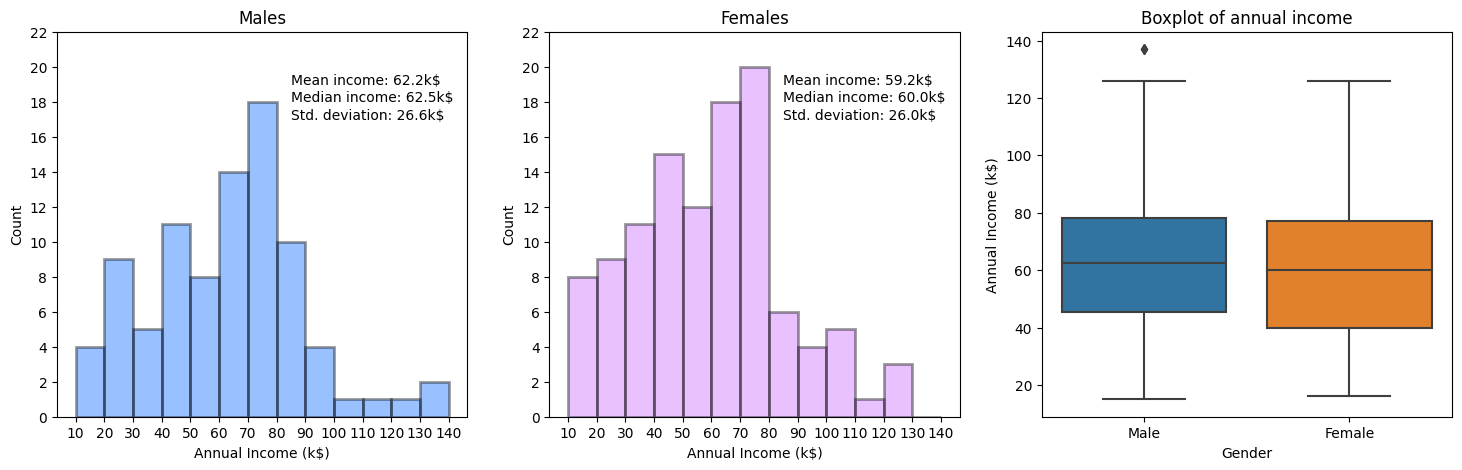

In [9]:
males_income = mall_data[mall_data['Gender']=='Male']['Annual Income (k$)'] # subset with males income
females_income = mall_data[mall_data['Gender']=='Female']['Annual Income (k$)'] # subset with females income

my_bins = range(10,150,10)

# males histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.distplot(males_income, bins=my_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(my_bins)
ax1.set_yticks(range(0,24,2))
ax1.set_ylim(0,22)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(85,19, "Mean income: {:.1f}k$".format(males_income.mean()))
ax1.text(85,18, "Median income: {:.1f}k$".format(males_income.median()))
ax1.text(85,17, "Std. deviation: {:.1f}k$".format(males_income.std()))

# females histogram
sns.distplot(females_income, bins=my_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(my_bins)
ax2.set_yticks(range(0,24,2))
ax2.set_ylim(0,22)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(85,19, "Mean income: {:.1f}k$".format(females_income.mean()))
ax2.text(85,18, "Median income: {:.1f}k$".format(females_income.median()))
ax2.text(85,17, "Std. deviation: {:.1f}k$".format(females_income.std()))

# boxplot
sns.boxplot(x='Gender', y='Annual Income (k$)', data=mall_data, ax=ax3)
ax3.set_title('Boxplot of annual income')
plt.show()

In [10]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_income, females_income)[1]))

Kolgomorov-Smirnov test p-value: 0.78


> - mean income of males is higher
- med income of male is higher
- std similar
- one outlier in male group
- K-S test: two groups are not statistically diff

### c. Spending Score

<ipython-input-11-95f80557e0ae>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(males_spending, bins=spending_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
<ipython-input-11-95f80557e0ae>:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(females_spending, 

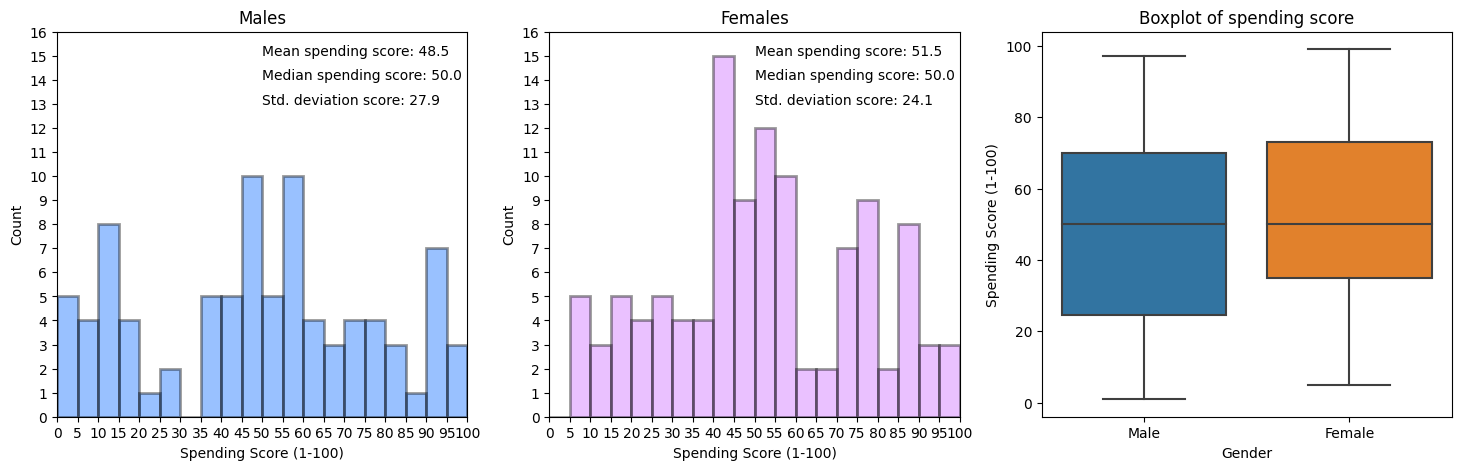

In [11]:
males_spending = mall_data[mall_data['Gender']=='Male']['Spending Score (1-100)'] # subset with males age
females_spending = mall_data[mall_data['Gender']=='Female']['Spending Score (1-100)'] # subset with females age

spending_bins = range(0,105,5)

# males histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.distplot(males_spending, bins=spending_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(spending_bins)
ax1.set_xlim(0,100)
ax1.set_yticks(range(0,17,1))
ax1.set_ylim(0,16)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(50,15, "Mean spending score: {:.1f}".format(males_spending.mean()))
ax1.text(50,14, "Median spending score: {:.1f}".format(males_spending.median()))
ax1.text(50,13, "Std. deviation score: {:.1f}".format(males_spending.std()))

# females histogram
sns.distplot(females_spending, bins=spending_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(spending_bins)
ax2.set_xlim(0,100)
ax2.set_yticks(range(0,17,1))
ax2.set_ylim(0,16)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(50,15, "Mean spending score: {:.1f}".format(females_spending.mean()))
ax2.text(50,14, "Median spending score: {:.1f}".format(females_spending.median()))
ax2.text(50,13, "Std. deviation score: {:.1f}".format(females_spending.std()))

# boxplot
sns.boxplot(x='Gender', y='Spending Score (1-100)', data=mall_data, ax=ax3)
ax3.set_title('Boxplot of spending score')
plt.show()

plt.show()

In [12]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_spending, females_spending)[1]))

Kolgomorov-Smirnov test p-value: 0.29


> - mean spending score for women is higher
- K-S test: no evidence to reject H0
- evidence is not so strong as previous

In [14]:
# median income for all age groups
medians_by_age_group = mall_data.groupby(["Gender",pd.cut(mall_data['Age'], age_bins)]).median()
medians_by_age_group.index = medians_by_age_group.index.set_names(['Gender', 'Age_group'])
medians_by_age_group.reset_index(inplace=True)

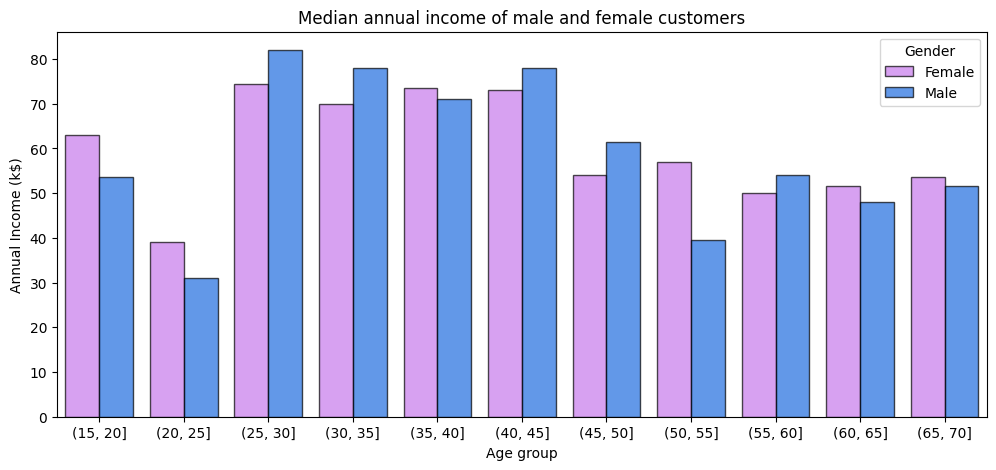

In [15]:
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(x='Age_group', y='Annual Income (k$)', hue='Gender', data=medians_by_age_group,
            palette=['#cc66ff','#0066ff'],
            alpha=0.7,edgecolor='k',
            ax=ax)
ax.set_title('Median annual income of male and female customers')
ax.set_xlabel('Age group')
plt.show()

> - the most wealthy customers: 25-45 yrs old
- biggest diff btw women & men is visible in 25-30 & 50-55

## 3.2 Correlations

### a. age & spending score


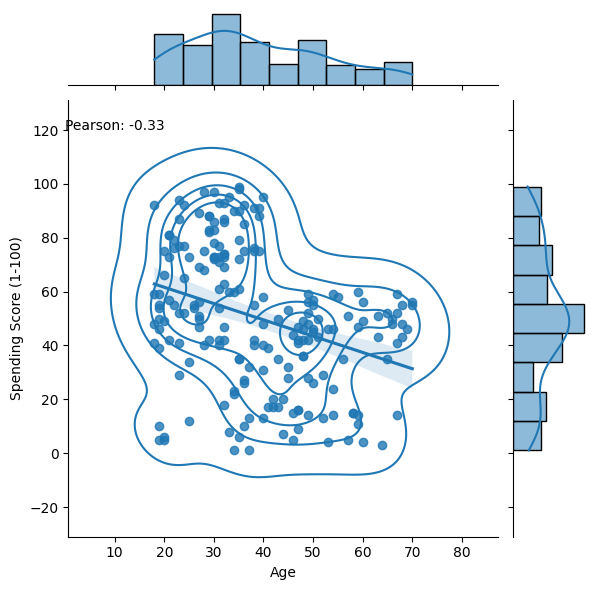

In [17]:
from scipy.stats import pearsonr

corr, _ = pearsonr(mall_data['Age'], mall_data['Spending Score (1-100)'])

jp = (sns.jointplot(x='Age', y='Spending Score (1-100)', data=mall_data,
                    kind='reg')).plot_joint(sns.kdeplot, zorder=0, n_levels=6)


plt.text(0,120, 'Pearson: {:.2f}'.format(corr))
plt.show()

### b. age & annual income

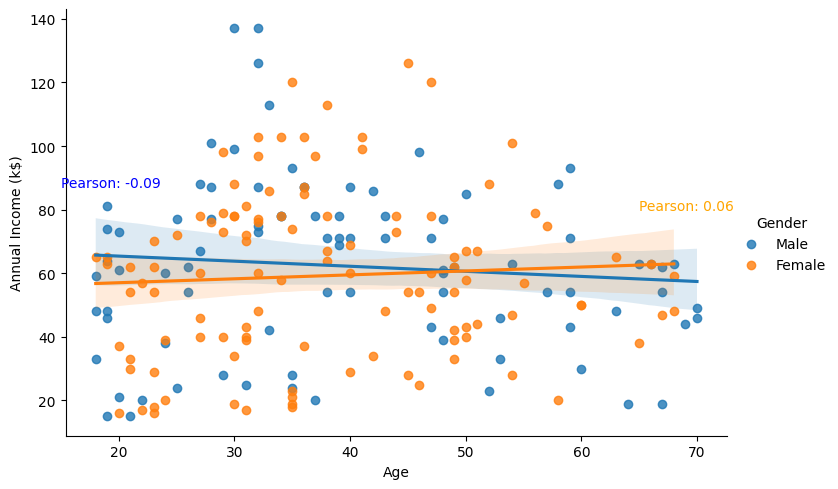

In [18]:
corr1, _ = pearsonr(males_age.values, males_income.values)
corr2, _ = pearsonr(females_age.values, females_income.values)

sns.lmplot(x='Age', y='Annual Income (k$)', data=mall_data, hue='Gender', aspect=1.5)

plt.text(15,87, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(65,80, 'Pearson: {:.2f}'.format(corr2), color='orange')

plt.show()

> no corr btw age & annual income

### c. age & spending score


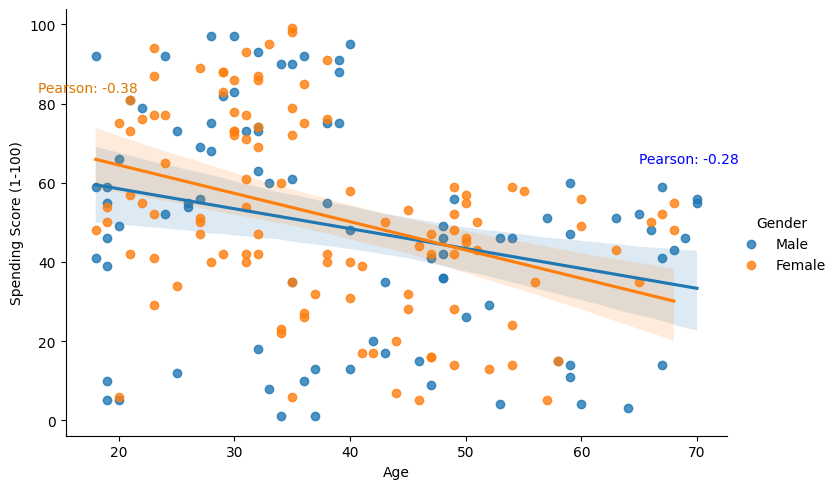

In [19]:
corr1, _ = pearsonr(males_age.values, males_spending.values)
corr2, _ = pearsonr(females_age.values, females_spending.values)

sns.lmplot(x='Age', y='Spending Score (1-100)', data=mall_data, hue='Gender', aspect=1.5)

plt.text(65,65, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(13,83, 'Pearson: {:.2f}'.format(corr2), color='#d97900')


plt.show()

> weak negative corr(<0.5) btw age & spending score for both sex groups

### d. annual income & spending score


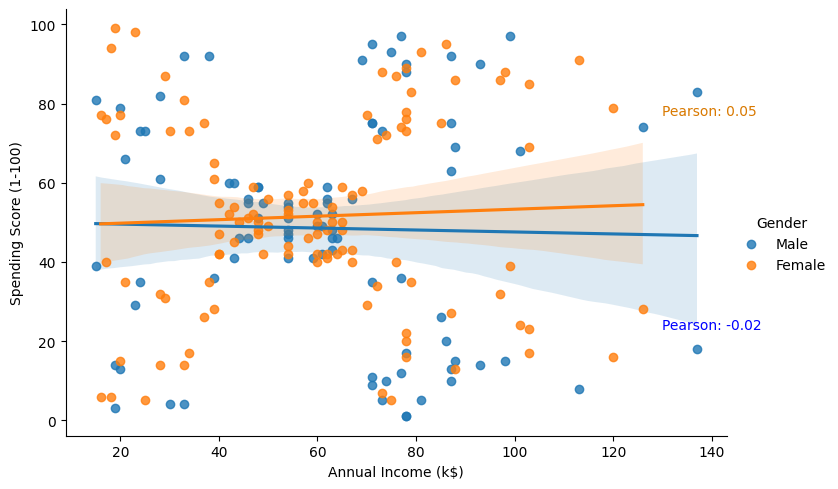

In [20]:
corr1, _ = pearsonr(males_income.values, males_spending.values)
corr2, _ = pearsonr(females_income.values, females_spending.values)

sns.lmplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=mall_data, hue='Gender', aspect=1.5)

plt.text(130,23, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(130,77, 'Pearson: {:.2f}'.format(corr2), color='#d97900')

plt.show()

> negligible corr btw annual income & spending score

# 4. Clustering
- k-means
- DBScan
- Affinity Propagation

standardize X

## 4.1 K-Means

### 4.1.1 Description
- ease of implementation, simplicity, empirical successes
- 3 main steps in K-Means algorithm
  
  1) Split samples into initial groups by using seed points
  - neareset samples to these seed point will create initial clusters

  2) calculate samples distances to groups' central points(centroids) and assign the nearest samples to their cluster
  
  3) calculate newly created cluster centroids

  -> then repeat 2), 3) until algorithm converges

- Goal of K-Means: to minimize the objective function(inertia) over clusters [NP-hard problem]
  - greedy algorithm
  - converges to the local minimum

- fast
- in case of groups are well isolated from each other: converges to the global minimum
  - bcz the result depends on initialisation

- K-Means requres three main parameters:

  1) Initialisation criteria
  
  2) Number of clusters

  3) Distance metric(not required in sklearn)


- take-aways about K-Means:

  1) Euclidean distances are used

  2) Number of clusters has to be defined for the algorithm

  3) Centroid is calculated using mean distance to cluster members

  4) Clusters are assumed isotropic and convex

  5) Stochastic algorithm – results depend on the initialisation criteria

  6) Creates groups of equal variance (minimises inertia)

  7) Prone to the “curse of dimensionality”

  8) Can be run in parallel – so it scales well

### 4.1.2 Use case - customers segmentation

In [22]:
from sklearn.cluster import KMeans

only use numerical. no gender here.

In [23]:
X_numerics = mall_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

- to find appropriate number of clusters
- **ELBOW METHOD** : to choose the number of clusters where we see kink(an elbow) in the gh
- inertia for a number of clusters btw 2 & 10 will be calculated


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

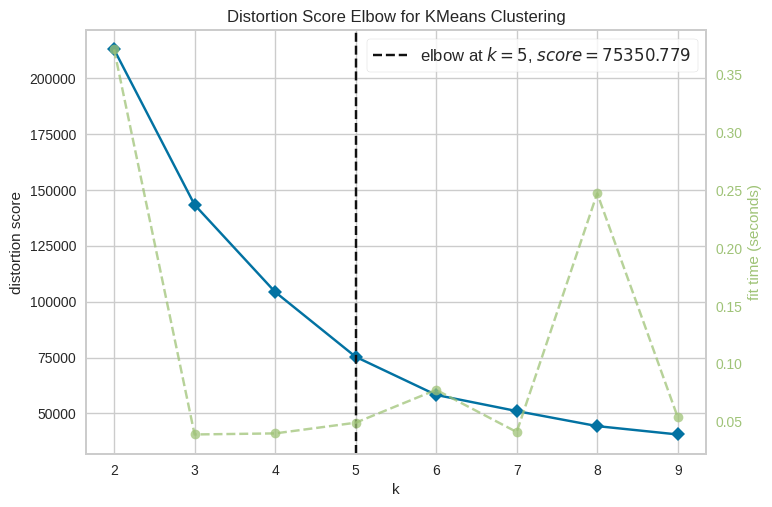

In [24]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(X_numerics)
visualizer.show()
plt.show()

>- no clear elbow visible (mabye 5~6?)


- **SILHUETTE SCORE**: another way to choose the best

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

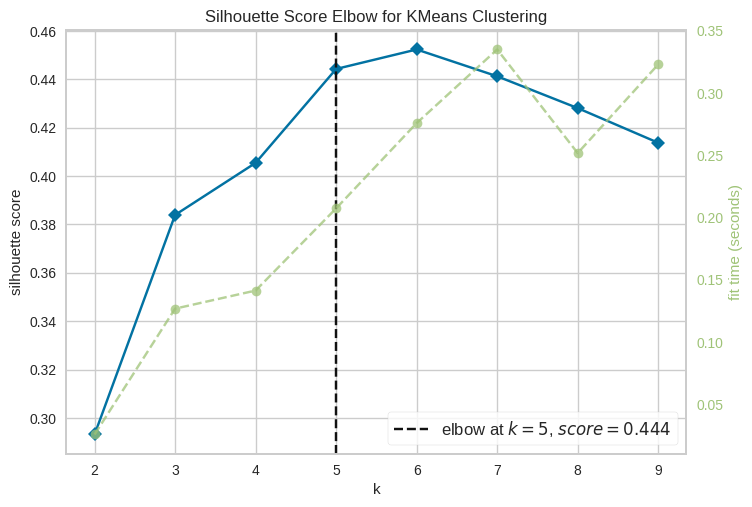

In [25]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette')

visualizer.fit(X_numerics)
visualizer.show()
plt.show()

>- 5~6.
- lets compare both.

---------------------------------------------------------
### a. 5 clusters

In [26]:
KM_5_clusters = KMeans(n_clusters=5, init='k-means++').fit(X_numerics) # initialise and fit K-Means model

KM5_clustered = X_numerics.copy()
KM5_clustered.loc[:,'Cluster'] = KM_5_clusters.labels_ # append labels to points

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


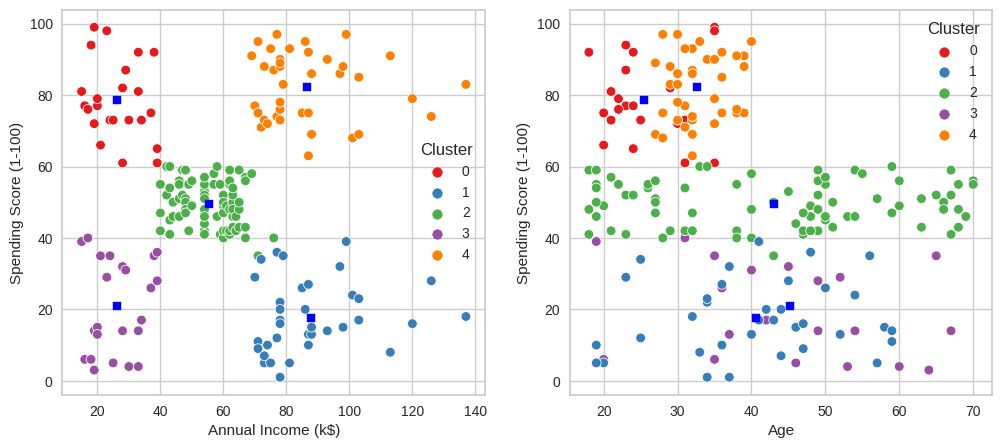

In [28]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))

scat_1 = sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=KM5_clustered,
                         hue='Cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot(x='Age', y='Spending Score (1-100)', data=KM5_clustered,
                hue='Cluster', palette='Set1', ax=axes[1], legend='full')

axes[0].scatter(KM_5_clusters.cluster_centers_[:,1],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_5_clusters.cluster_centers_[:,0],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

>- K-Means algorithm generated 5 clusters
- No distinct groups in terms of customers age

In [29]:
# Size of clusters
KM_clust_sizes = KM5_clustered.groupby('Cluster').size().to_frame()
KM_clust_sizes.columns = ["KM_size"]
KM_clust_sizes

,KM_size
Cluster,
0,23
1,36
2,79
3,23
4,39


>- The biggest: Cluster 2 (79 Observations)
- The smallest: Cluster 0, Cluster 3(23 Observations)

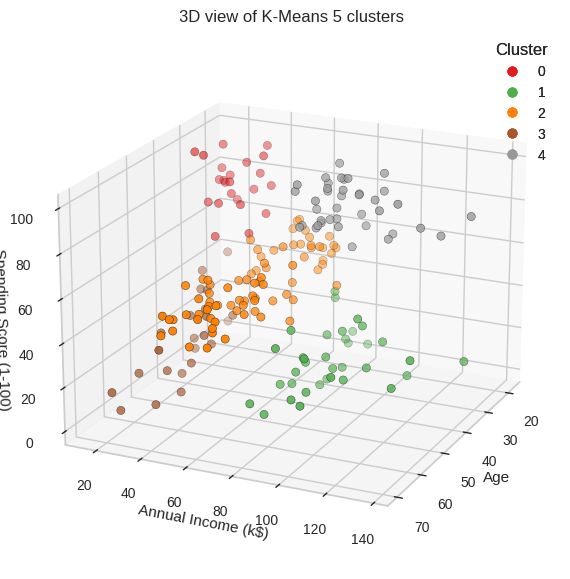

In [30]:
# 3D projection of 5 generated clusters
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d', elev=20, azim=210)
scatter = ax.scatter(KM5_clustered['Age'],
                     KM5_clustered['Annual Income (k$)'],
                     KM5_clustered['Spending Score (1-100)'],
                     c=KM5_clustered['Cluster'],
                     s = 35, edgecolor = 'k', cmap = plt.cm.Set1)

ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title('3D view of K-Means 5 clusters')
ax.azim = 25

# Create a legend with the unique colors from the scatter
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Cluster")
ax.add_artist(legend)

plt.show()

In [31]:
# Plotly version:
import plotly as py
import plotly.graph_objs as go

def tracer(db, n, name):
    '''
    This function returns trace object for Plotly
    '''
    return go.Scatter3d(
        x = db[db['Cluster']==n]['Age'],
        y = db[db['Cluster']==n]['Spending Score (1-100)'],
        z = db[db['Cluster']==n]['Annual Income (k$)'],
        mode = 'markers',
        name = name,
        marker = dict(
            size = 5
        )
     )

trace0 = tracer(KM5_clustered, 0, 'Cluster 0')
trace1 = tracer(KM5_clustered, 1, 'Cluster 1')
trace2 = tracer(KM5_clustered, 2, 'Cluster 2')
trace3 = tracer(KM5_clustered, 3, 'Cluster 3')
trace4 = tracer(KM5_clustered, 4, 'Cluster 4')

data = [trace0, trace1, trace2, trace3, trace4]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

Silhuette Plot: to check the quality of each cluster

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



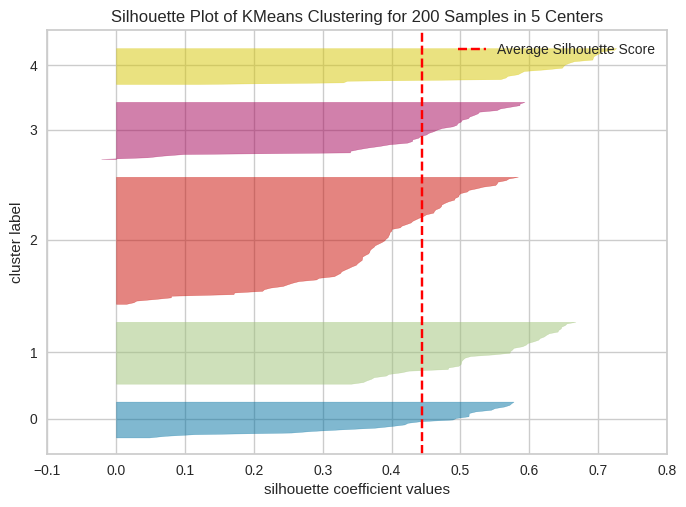

In [32]:
from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(n_clusters = 5, random_state = 0)
visualizer = SilhouetteVisualizer(model, colors = 'yellowbrick')
visualizer.fit(X_numerics)
visualizer.show()
plt.show()

---------------------------------------------------------
### b. 6 clusters

In [33]:
KM_6_clusters = KMeans(n_clusters = 6, init = 'k-means++').fit(X_numerics) # initialise and fit K-Means model

KM6_clustered = X_numerics.copy()
KM6_clustered.loc[:,'Cluster'] = KM_6_clusters.labels_ # append labels to points

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



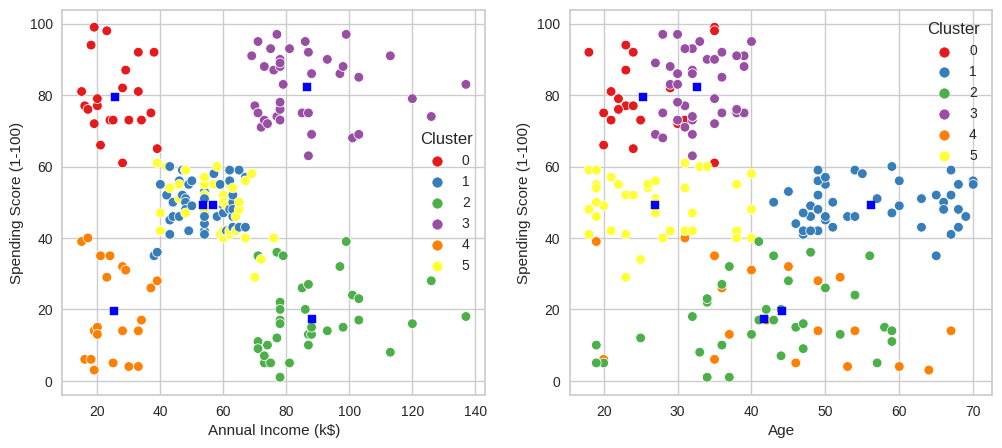

In [34]:
fig11, (axes) = plt.subplots(1,2,figsize=(12,5))

sns.scatterplot(x = 'Annual Income (k$)', y = 'Spending Score (1-100)', data=KM6_clustered,
                hue='Cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot(x = 'Age', y = 'Spending Score (1-100)', data = KM6_clustered,
                hue='Cluster', palette='Set1', ax=axes[1], legend='full')


# plotting centroids
axes[0].scatter(KM_6_clusters.cluster_centers_[:,1], KM_6_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_6_clusters.cluster_centers_[:,0], KM_6_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

> - K-Means Algorithm generated 6 clusters
- There are no distinct groups in terms of customers age


In [35]:
KM6_clust_sizes = KM6_clustered.groupby('Cluster').size().to_frame()
KM6_clust_sizes.columns = ["KM_size"]
KM6_clust_sizes

,KM_size
Cluster,
0,22
1,45
2,35
3,39
4,21
5,38


In [36]:
# Plotly interactive 3D plot

trace0 = tracer(KM6_clustered, 0, 'Cluster 0')
trace1 = tracer(KM6_clustered, 1, 'Cluster 1')
trace2 = tracer(KM6_clustered, 2, 'Cluster 2')
trace3 = tracer(KM6_clustered, 3, 'Cluster 3')
trace4 = tracer(KM6_clustered, 4, 'Cluster 4')
trace5 = tracer(KM6_clustered, 5, 'Cluster 5')

data = [trace0, trace1, trace2, trace3, trace4, trace5]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



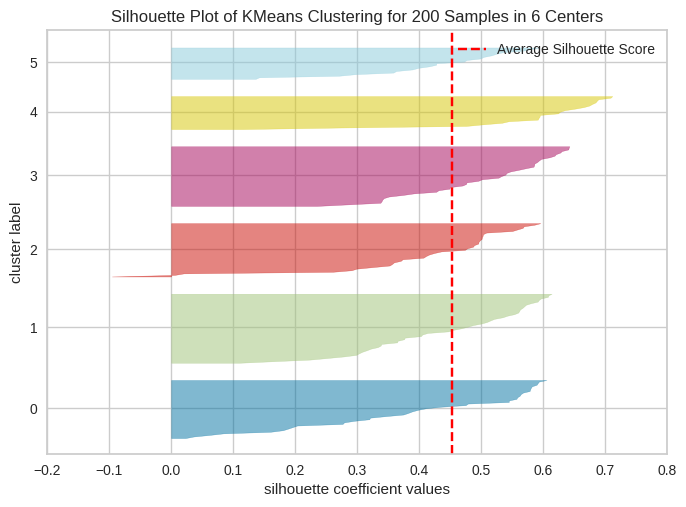

In [37]:
model = KMeans(n_clusters=6, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_numerics)
visualizer.show()
plt.show()

## 4.2 DBSCAN

### 4.2.1 Description
- Density-Based Spatial Clustering of Applications with Noise
- core idea of DBSCAN: around concept of dense regions
- assumption: natural clusters are composed of densely located points

- Advantages of this approach:

  - it finds number of clusters itself, based on eps and MinPts parameters
  - It it able to differentiate elongated clusters or clusters surrounded by other clusters in contrary to e.g. K-Means where clusters are always convex.
  - It is also able to find points not fitting into any cluster – it detects outliers.

- The biggest drawback of DBSCAN:

  - High computational expense of average O(n log(n)) coming from a need to execute a neighbourhood query for each point.
  - Poorly identifies clusters with various densities

### 4.2.2 Use case - customers segmentation

In [38]:
from sklearn.cluster import DBSCAN

In [39]:
# create a matrix of investigated combinations: eps, min_samples
from itertools import product

eps_values = np.arange(8,12.75,0.25) # eps
min_samples = np.arange(3,10) # min_samples

DBSCAN_params = list(product(eps_values, min_samples))

In [40]:
# check the number of generated clusters
from sklearn.metrics import silhouette_score

no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(X_numerics)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(X_numerics, DBS_clustering.labels_))

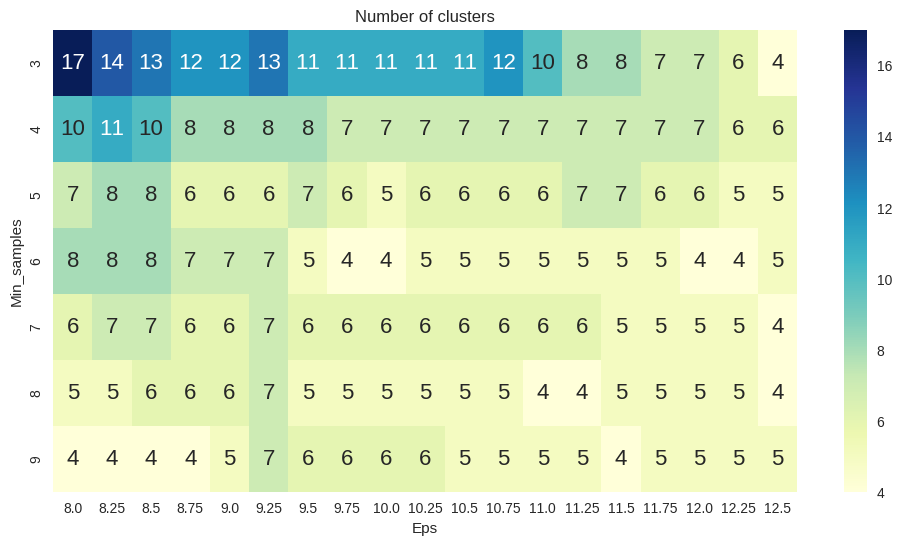

In [41]:
# how many clusters were generated by DBSCAN
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()

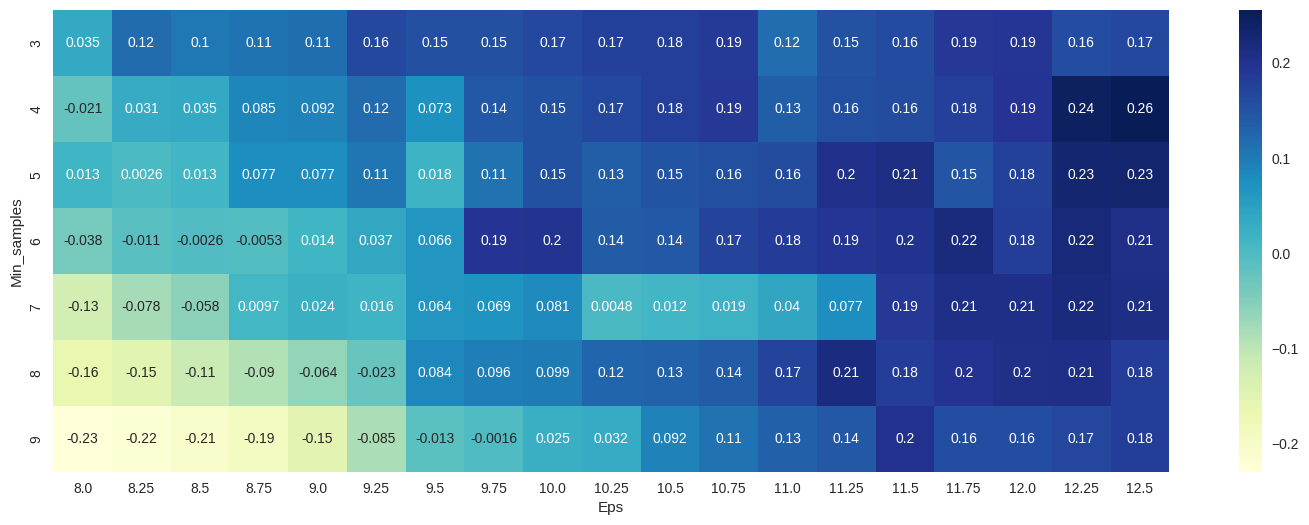

In [42]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

In [43]:
DBS_clustering = DBSCAN(eps = 12.5, min_samples = 4).fit(X_numerics)

DBSCAN_clustered = X_numerics.copy()
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_ # append labels to points

In [44]:
# Checking sizes of clusters
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes

,DBSCAN_size
Cluster,
-1,18
0,112
1,8
2,34
3,24
4,4


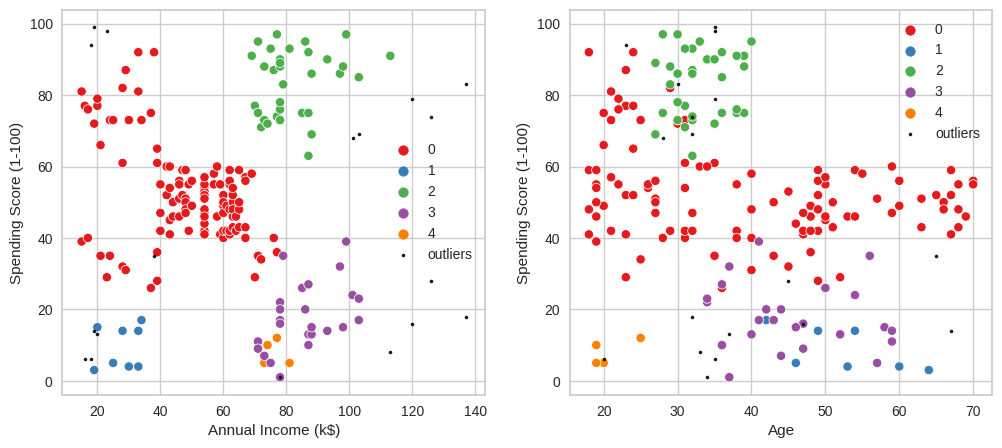

In [45]:
outliers = DBSCAN_clustered[DBSCAN_clustered['Cluster']==-1]

fig2, (axes) = plt.subplots(1,2,figsize=(12,5))

sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', ax=axes[0], palette='Set1', legend='full', s=45)

sns.scatterplot(x='Age', y='Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', palette='Set1', ax=axes[1], legend='full', s=45)

axes[0].scatter(outliers['Annual Income (k$)'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[1].scatter(outliers['Age'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[0].legend()
axes[1].legend()

plt.setp(axes[0].get_legend().get_texts(), fontsize='10')
plt.setp(axes[1].get_legend().get_texts(), fontsize='10')

plt.show()

## 4.3 Affinity Propagation
### 4.3.1 Description
- built around the concept of sending messages between a pair of points until it converges
- The algorithm finds an optimum number of clusters itself
- very high time complexity cost of the order O(n²T) where n is the number of samples and T is the number of iterations until convergence
- big advantage of AP : the lack of sensitivity to the initialisation criteria



### 4.3.2 Use case - customers segmentation

In [46]:
from sklearn.cluster import AffinityPropagation

In [47]:
no_of_clusters = [] # 클러스터의 개수
preferences = range(-20000,-5000,100) # 임의로 선택된 범위
af_sil_score = [] # 실루엣 계수

for p in preferences:
    AF = AffinityPropagation(preference = p, max_iter = 200).fit(X_numerics)
    no_of_clusters.append((len(np.unique(AF.labels_))))
    af_sil_score.append(silhouette_score(X_numerics, AF.labels_))

af_results = pd.DataFrame([preferences, no_of_clusters, af_sil_score],
                          index=['preference','clusters', 'sil_score']).T
af_results.sort_values(by = 'sil_score', ascending = False).head() # 최적의 5개 점수를 출력

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.



,preference,clusters,sil_score
82,-11800.0,6.0,0.451649
27,-17300.0,6.0,0.451491
51,-14900.0,6.0,0.451491
52,-14800.0,6.0,0.451440
28,-17200.0,6.0,0.451440


In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(x = preferences, y = af_sil_score, marker = 'o', ax = ax)
ax.set_title("Silhouette score method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("Silhouette score")
ax.axvline(-11800, ls="--", c="red")
plt.grid()
plt.show()

In [48]:
AF = AffinityPropagation(preference=-11800).fit(X_numerics)

In [49]:
AF_clustered = X_numerics.copy()
AF_clustered.loc[:,'Cluster'] = AF.labels_ # append labels to points

In [50]:
AF_clust_sizes = AF_clustered.groupby('Cluster').size().to_frame()
AF_clust_sizes.columns = ["AF_size"]
AF_clust_sizes

,AF_size
Cluster,
0,22
1,22
2,44
3,39
4,34
5,39


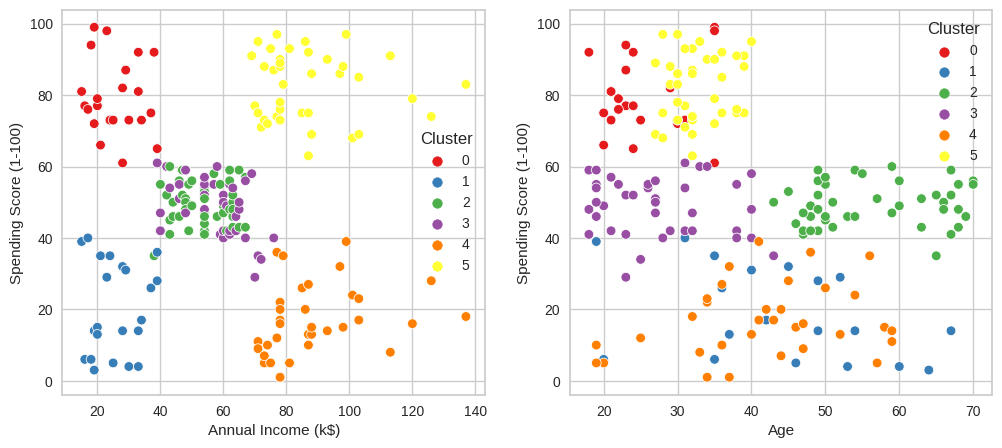

In [51]:
fig3, (ax_af) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=AF_clustered,
                         hue='Cluster', ax=ax_af[0], palette='Set1', legend='full')

sns.scatterplot(x='Age', y='Spending Score (1-100)', data=AF_clustered,
                hue='Cluster', palette='Set1', ax=ax_af[1], legend='full')

plt.setp(ax_af[0].get_legend().get_texts(), fontsize='10')
plt.setp(ax_af[1].get_legend().get_texts(), fontsize='10')
plt.show()

# 5. Comparison and discussion
#### K-Means(5 clusters)

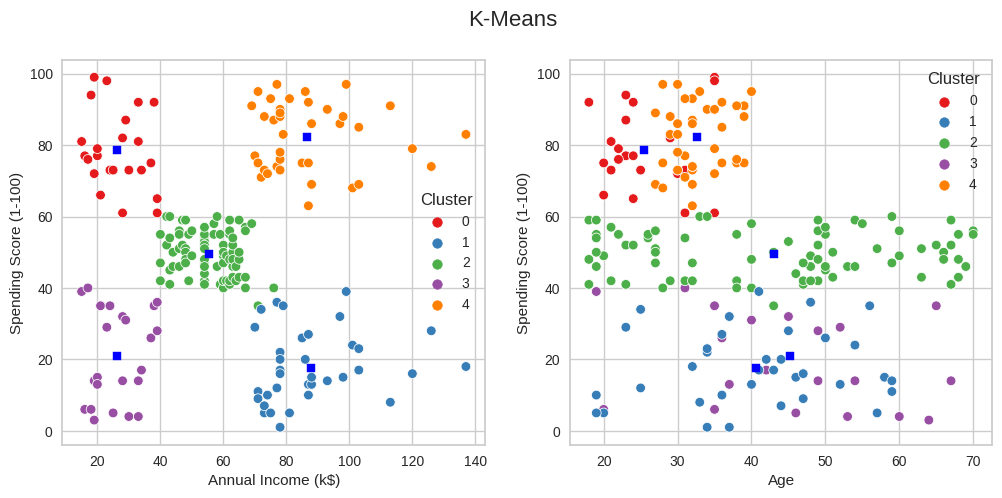

In [52]:
fig1.suptitle('K-Means', fontsize=16)
fig1

#### K-Means(6 clusters)

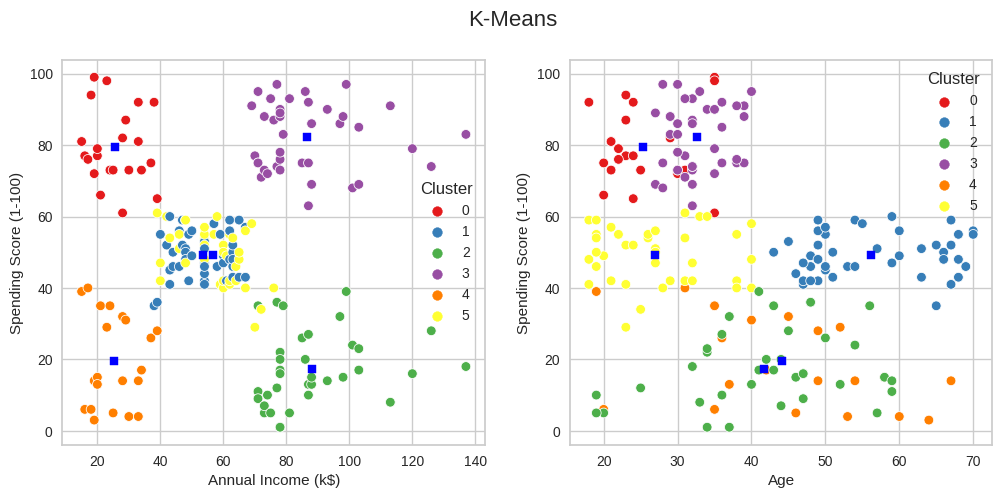

In [53]:
fig11.suptitle('K-Means', fontsize=16)
fig11

#### DBSCAN

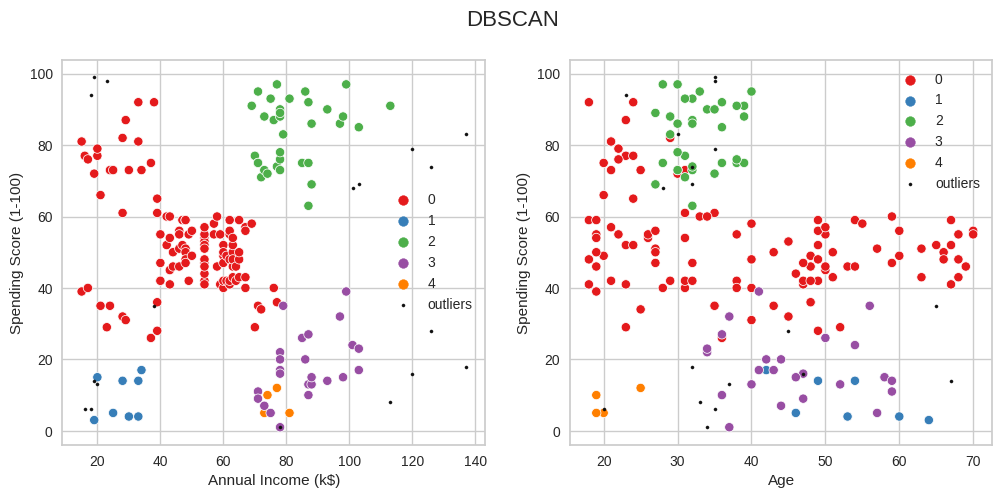

In [54]:
fig2.suptitle('DBSCAN', fontsize=16)
fig2

#### AP

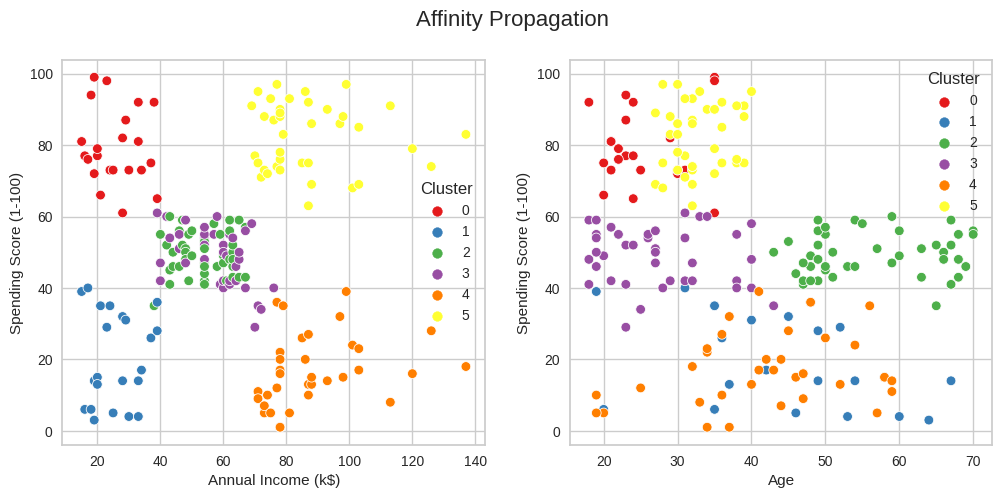

In [55]:
fig3.suptitle('Affinity Propagation', fontsize=16)
fig3

In [56]:
clusters = pd.concat([KM6_clust_sizes, DBSCAN_clust_sizes, AF_clust_sizes],axis=1, sort=False)
clusters

,KM_size,DBSCAN_size,AF_size
Cluster,,,
0,22.0,112.0,22.0
1,45.0,8.0,22.0
2,35.0,34.0,44.0
3,39.0,24.0,39.0
4,21.0,4.0,34.0
5,38.0,NaN,39.0
-1,NaN,18.0,NaN


> - DBSCAN failed to generate reasonable clusters
  - bcz: DBSCAN tries to find clusters based on the density of points
  - if one of clusters is less dense then others, DBSCAN will produce suboptimal results by not recognizing the least dense group as a cluster
- K-Means & AP created reasonable 6 clusters